In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

## Training of GNN model (loss vs iteration)

(0.05, 0.2)

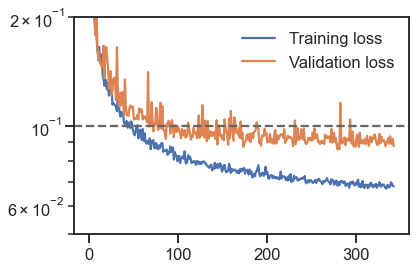

In [76]:
log = pd.read_csv('trained_model/log.csv')

plt.semilogy(log.epoch, log.loss, label='Training loss')
plt.semilogy(log.epoch, log.val_loss, label='Validation loss')
plt.axhline(.1, ls='--', color='.4')
plt.legend()
plt.ylim([0.05, 0.2])

## Load the model and preprocessor

In [14]:
import pickle
import tensorflow as tf
import nfp
from nfp_extensions import RBFExpansion

with open('tfrecords/preprocessor.p', 'rb') as f:
    preprocessor = pickle.load(f)
    
model = tf.keras.models.load_model(
    'trained_model/best_model.hdf5',
    custom_objects={**nfp.custom_objects, **{'RBFExpansion': RBFExpansion}})

## Load the test data and convert to model inputs (using pymatgen)

In [41]:
from pymatgen.core.structure import Structure
from tqdm import tqdm

In [42]:
test = pd.read_csv('test.csv.gz')

cif_file = lambda x: '/scratch/pstjohn/utf8_cifs/icsd_{:06d}.cif'.format(x)
get_crystal = lambda x: Structure.from_file(cif_file(x), primitive=True)

Example crystal parsing

In [43]:
get_crystal(test.icsdnum.iloc[1])

Structure Summary
Lattice
    abc : 3.987 7.109 10.13106762636594
 angles : 95.74504457058197 101.34819731135227 90.0
 volume : 280.0655935711522
      A : 6.41158500426075e-16 3.987 2.4413333941002486e-16
      B : -0.0 -0.0 7.109
      C : 9.881093493760199 -1.9935 -1.0141402110013504
PeriodicSite: Cu+ (4.2064, 1.9935, 2.6188) [0.7128, 0.4291, 0.4257]
PeriodicSite: Cu+ (5.6747, -0.0000, 3.4761) [0.2872, 0.5709, 0.5743]
PeriodicSite: Cu+ (9.0003, 1.9935, 5.0876) [0.9554, 0.8456, 0.9109]
PeriodicSite: Cu+ (0.8808, -0.0000, 1.0072) [0.0446, 0.1544, 0.0891]
PeriodicSite: Te2- (4.9911, 1.9935, 5.1096) [0.7526, 0.7908, 0.5051]
PeriodicSite: Te2- (4.8900, 0.0000, 0.9853) [0.2474, 0.2092, 0.4949]
PeriodicSite: Te2- (8.1369, 1.9935, 0.3842) [0.9117, 0.1715, 0.8235]
PeriodicSite: Te2- (1.7442, 0.0000, 5.7106) [0.0883, 0.8285, 0.1765]
PeriodicSite: Te2- (1.6183, 1.9935, 2.4606) [0.5819, 0.3695, 0.1638]
PeriodicSite: Te2- (8.2628, 0.0000, 3.6343) [0.4181, 0.6305, 0.8362]
PeriodicSite: Ti4+ (2.89

Create a tf.data pipeline

In [45]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(get_crystal(icsdnum), train=False)
             for icsdnum in tqdm(test.icsdnum)),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128,
                  padded_shapes=preprocessor.padded_shapes(),
                  padding_values=preprocessor.padding_values)

## Predict the test crystals.
The slow step here is definitely loading the CIF files and creating the primitive cell

In [47]:
predictions = model.predict(test_dataset)

  0%|          | 0/500 [00:00<?, ?it/s]/projects/rlmolecule/pstjohn/envs/tf2/lib/python3.7/site-packages/pymatgen/io/cif.py:1121: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))
100%|██████████| 500/500 [01:43<00:00,  4.84it/s]


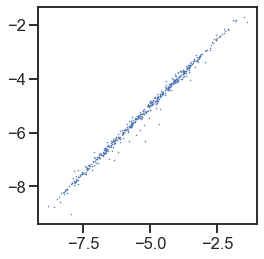

In [51]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(test.energyperatom, predictions, '.', ms=1)

## Test set MAE

In [57]:
(test.energyperatom - predictions.squeeze()).abs().mean()

0.08171833975459976

Looks like we can speed up evaluation at test-time by not creating the primitive crystal. And good to validate that the predictions are (almost) identical between the two methods. Note, this changes the underlying graph structure as well

In [58]:
get_crystal_no_primitive = lambda x: Structure.from_file(cif_file(x), primitive=False)
test_dataset_no_primitive = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(
        get_crystal_no_primitive(icsdnum), train=False)
             for icsdnum in tqdm(test.icsdnum)),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128,
                  padded_shapes=preprocessor.padded_shapes(),
                  padding_values=preprocessor.padding_values)

predictions_no_primitive = model.predict(test_dataset_no_primitive)

  0%|          | 0/500 [00:00<?, ?it/s]/projects/rlmolecule/pstjohn/envs/tf2/lib/python3.7/site-packages/pymatgen/io/cif.py:1121: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))
100%|██████████| 500/500 [00:23<00:00, 21.27it/s]


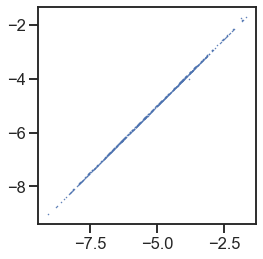

In [61]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax = plt.plot(predictions, predictions_no_primitive, '.', ms=1)

Might be worth looking into why we're not getting perfect predictions for these

In [75]:
test['prim_err'] = np.abs(predictions_no_primitive - predictions)
test.sort_values('prim_err', ascending=False).head(10)

,icsdnum,numatom,initialspacegroupnum,energyperatom,prim_err
346,616526,2,166,-4.059750,0.174068
64,22271,4,12,-1.373983,0.131992
407,130046,20,136,-4.239290,0.044361
130,169765,10,140,-5.413925,0.033793
77,52472,4,123,-6.413760,0.021711
342,92577,14,229,-6.630195,0.020465
451,80830,12,14,-7.765510,0.010373
95,240440,20,139,-7.270744,0.007977
425,250389,8,43,-3.833759,0.004002
313,280519,22,167,-5.656196,0.003998
